# Looking at BCR data in all-cells object to mark non-B cells with BCR information as doublets

CVID, revisions

analysis with scirpy

02.2021: reanalysis of twin activation data after bertie bug correction

In [1]:
import scirpy as ir # requires 'pip install scirpy'
import scanpy as sc
from glob import glob
import pandas as pd
import numpy as np
import tarfile
import anndata
import warnings
from numba import NumbaPerformanceWarning

# ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.set_figure_params(dpi=100)


In [3]:
%%bash

pip freeze

aiohttp==3.6.2
airr==1.3.1
alembic==1.3.0
anndata==0.7.5
annoy==1.16.2
async-generator==1.10
async-timeout==3.0.1
attrs==19.3.0
backcall==0.1.0
bbknn==1.3.6
bleach==3.1.0
blinker==1.4
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
Click==7.0
conda==4.7.12
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
Cython==0.29.14
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fbpca==1.0
geosketch==1.0
get-version==2.1
h5py==2.10.0
idna==2.8
imageio==2.9.0
importlib-metadata==0.23
intervaltree==2.1.0
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
jedi==0.15.1
Jinja2==2.10.3
joblib==0.14.0
json5==0.8.5
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
jupyter-rsession-proxy==1.0b6
jupyter-server-proxy==1.2.0
jupyterhub==1.0.0
jupyterlab==1.2.1
jupyterlab-server==1.0.6
kiwisolver==1.1.0
legacy-api-wrap==1.2
leidenalg==0.7.0
llvmlite==0.30.0
loompy==3.0.6
louvain==0.6.1
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.3.4
mistune==0.8.4
more-itertools==

## Reading in the main transcriptomics object

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

In [6]:
# object with all cells, norm., log tr and scaled gex counts in .X, norm. and log tr. gex counts in .raw.X, HVG-subsetted
adata = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs.h5ad')

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [7]:
adata

AnnData object with n_obs × n_vars = 17315 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'activation_colors', 'ccgs', 'celltype_predictions_colors', 'condition_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
# complete metadata
#obs_metadata = pd.read_csv(save_path + '20210104_obs_table_final_object.csv', index_col=0)
#obs_metadata

In [9]:
# adding complete metadata to the current object
#for col in obs_metadata.columns:
#    print(col)
#    adata.obs[col] = obs_metadata.loc[adata.obs_names, col]

In [10]:
adata

AnnData object with n_obs × n_vars = 17315 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'activation_colors', 'ccgs', 'celltype_predictions_colors', 'condition_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Loading data from cellranger output

#### general scRNA-seq

Immunodeficiency8103070          CVID_CTRL_Bcells

Immunodeficiency8103072          CVID_CD40L_Bcells

Immunodeficiency8103073          CVID_CD3_Bcells

Immunodeficiency8103074          CONTROL_CTRL_Bcells

Immunodeficiency8103076          CONTROL_CD40L_Bcells

Immunodeficiency8103077          CONTROL_CD3_Bcells

#### BCR enriched

Immunodeficiency8103054          CVID_CTRL_Bcells_B

Immunodeficiency8103056          CVID_CD40L_Bcells_B

Immunodeficiency8103057          CVID_CD3_Bcells_B

Immunodeficiency8103058          CONTROL_CTRL_Bcells_B

Immunodeficiency8103060          CONTROL_CD40L_Bcells_B

Immunodeficiency8103061          CONTROL_CD3_Bcells_B

In [13]:
samples_enriched = ['Immunodeficiency8103054',
                   'Immunodeficiency8103056',
                   'Immunodeficiency8103057',
                   'Immunodeficiency8103058',
                   'Immunodeficiency8103060',
                   'Immunodeficiency8103061']

In [14]:
np.unique(adata.obs['sample'])

array(['Immunodeficiency8103070', 'Immunodeficiency8103072',
       'Immunodeficiency8103073', 'Immunodeficiency8103074',
       'Immunodeficiency8103076', 'Immunodeficiency8103077'], dtype=object)

In [19]:
dict_samples_enrich_to_general =  {}

# BCR

dict_samples_enrich_to_general['Immunodeficiency8103054'] = 'Immunodeficiency8103070'
dict_samples_enrich_to_general['Immunodeficiency8103056'] = 'Immunodeficiency8103072'
dict_samples_enrich_to_general['Immunodeficiency8103057'] = 'Immunodeficiency8103073'
dict_samples_enrich_to_general['Immunodeficiency8103058'] = 'Immunodeficiency8103074'
dict_samples_enrich_to_general['Immunodeficiency8103060'] = 'Immunodeficiency8103076'
dict_samples_enrich_to_general['Immunodeficiency8103061'] = 'Immunodeficiency8103077'

In [20]:
list(dict_samples_enrich_to_general.keys())[:1]

['Immunodeficiency8103054']

In [23]:
%%time

# Create a list of AnnData objects (one for each sample)
adatas_gex_with_bcr = {}
for sample_bcr, sample_gex in dict_samples_enrich_to_general.items():
    
    print('gex sample', sample_gex)
    print('BCR sample', sample_bcr)
    
    gex_path = '/home/jovyan/notebooks/Vento_Lab/CVID/activation_matrices/filtered_feature_bc_matrix_' + sample_gex + '.h5'
    bcr_path = '/lustre/scratch117/cellgen/team292/aa22/data/CVID_related/cellranger_vdj_CVID_activation/' + sample_bcr + '/filtered_contig_annotations.csv'
    
    print('reading files')
    
    adata_gex = sc.read_10x_h5(gex_path)
    # remembering the unique barcode_sample index
    adata_gex.obs['barcode_sample'] = [barcode + '_' + sample_gex for barcode in adata_gex.obs_names]
    adata_bcr = ir.io.read_10x_vdj(bcr_path)
    
    print('merging gex and BCR adatas')
    
    ir.pp.merge_with_ir(adata_gex, adata_bcr)
    
    print('done merging')
    
    # concatenation only works with unique gene names
    adata_gex.var_names_make_unique()
    adatas_gex_with_bcr[sample_gex] = adata_gex


gex sample Immunodeficiency8103070
BCR sample Immunodeficiency8103054
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample Immunodeficiency8103072
BCR sample Immunodeficiency8103056
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample Immunodeficiency8103073
BCR sample Immunodeficiency8103057
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


done merging
gex sample Immunodeficiency8103074
BCR sample Immunodeficiency8103058
reading files


... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample Immunodeficiency8103076
BCR sample Immunodeficiency8103060
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical


merging gex and BCR adatas


... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
gex sample Immunodeficiency8103077
BCR sample Immunodeficiency8103061
reading files


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical


merging gex and BCR adatas


... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


done merging
CPU times: user 20.3 s, sys: 14 s, total: 34.3 s
Wall time: 35 s


In [24]:
# Merge anndata objects
adata_with_bcr = list(adatas_gex_with_bcr.values())[0].concatenate(list(adatas_gex_with_bcr.values())[1:])

In [25]:
adata_with_bcr

AnnData object with n_obs × n_vars = 19023 × 33694
    obs: 'barcode_sample', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [26]:
adata_with_bcr.obs

barcode_sample  \
AAACCTGCAGACAAGC-1-0  AAACCTGCAGACAAGC-1_Immunodeficiency8103070   
AAACCTGCATGTTCCC-1-0  AAACCTGCATGTTCCC-1_Immunodeficiency8103070   
AAACCTGGTCTCTCTG-1-0  AAACCTGGTCTCTCTG-1_Immunodeficiency8103070   
AAACCTGTCGAACTGT-1-0  AAACCTGTCGAACTGT-1_Immunodeficiency8103070   
AAACGGGAGATGAGAG-1-0  AAACGGGAGATGAGAG-1_Immunodeficiency8103070   
...                                                          ...   
TTTGTCACATGGTCAT-1-5  TTTGTCACATGGTCAT-1_Immunodeficiency8103077   
TTTGTCAGTAAATGTG-1-5  TTTGTCAGTAAATGTG-1_Immunodeficiency8103077   
TTTGTCAGTATCTGCA-1-5  TTTGTCAGTATCTGCA-1_Immunodeficiency8103077   
TTTGTCAGTCAATACC-1-5  TTTGTCAGTCAATACC-1_Immunodeficiency8103077   
TTTGTCAGTTGAACTC-1-5  TTTGTCAGTTGAACTC-1_Immunodeficiency8103077   

                     IR_VJ_1_locus IR_VJ_2_locus IR_VDJ_1_locus  \
AAACCTGCAGACAAGC-1-0           NaN           NaN            NaN   
AAACCTGCATGTTCCC-1-0           NaN           NaN            NaN   
AAACCTGGTCTCTCTG-1-0           NaN           NaN            NaN   
AAACCTGTCGAACTGT-1-0           NaN           NaN            NaN   
AAACGGGAGATGAGAG-1-0           NaN           NaN            NaN   
...                            ...           ...            ...   
TTTGTCACATGGTCAT-1-5           NaN           NaN            NaN   
TTTGTCAGTAAATGTG-1-5           IGK           NaN            IGH   
TTTGTCAGTATCTGCA-1-5           IGL           NaN            NaN   
TTTGTCAGTCAATACC-1-5           IGK           NaN            IGH   
TTTGTCAGTTGAACTC-1-5           NaN           NaN            NaN   

                     IR_VDJ_2_locus   IR_VJ_1_cdr3 IR_VJ_2_cdr3  \
AAACCTGCAGACAAGC-1-0            NaN            NaN          NaN   
AAACCTGCATGTTCCC-1-0            NaN            NaN          NaN   
AAACCTGGTCTCTCTG-1-0            NaN            NaN          NaN   
AAACCTGTCGAACTGT-1-0            NaN            NaN          NaN   
AAACGGGAGATGAGAG-1-0            NaN            NaN          NaN   
...                             ...            ...          ...   
TTTGTCACATGGTCAT-1-5            NaN            NaN          NaN   
TTTGTCAGTAAATGTG-1-5            NaN    CQQYNSYSRTF         None   
TTTGTCAGTATCTGCA-1-5            NaN  CSSYAGSNNFVVF         None   
TTTGTCAGTCAATACC-1-5            NaN    CQQSYSTPLTF         None   
TTTGTCAGTTGAACTC-1-5            NaN            NaN          NaN   

                        IR_VDJ_1_cdr3 IR_VDJ_2_cdr3  \
AAACCTGCAGACAAGC-1-0              NaN           NaN   
AAACCTGCATGTTCCC-1-0              NaN           NaN   
AAACCTGGTCTCTCTG-1-0              NaN           NaN   
AAACCTGTCGAACTGT-1-0              NaN           NaN   
AAACGGGAGATGAGAG-1-0              NaN           NaN   
...                               ...           ...   
TTTGTCACATGGTCAT-1-5              NaN           NaN   
TTTGTCAGTAAATGTG-1-5    CARSHTEAVGSYW          None   
TTTGTCAGTATCTGCA-1-5             None          None   
TTTGTCAGTCAATACC-1-5  CARGGSYYYYYMDVW          None   
TTTGTCAGTTGAACTC-1-5              NaN           NaN   

                                              IR_VJ_1_cdr3_nt  ...  \
AAACCTGCAGACAAGC-1-0                                      NaN  ...   
AAACCTGCATGTTCCC-1-0                                      NaN  ...   
AAACCTGGTCTCTCTG-1-0                                      NaN  ...   
AAACCTGTCGAACTGT-1-0                                      NaN  ...   
AAACGGGAGATGAGAG-1-0                                      NaN  ...   
...                                                       ...  ...   
TTTGTCACATGGTCAT-1-5                                      NaN  ...   
TTTGTCAGTAAATGTG-1-5        TGCCAACAGTATAATAGTTATTCAAGAACGTTC  ...   
TTTGTCAGTATCTGCA-1-5  TGCAGCTCATATGCAGGCAGCAACAATTTCGTGGTATTC  ...   
TTTGTCAGTCAATACC-1-5        TGTCAACAGAGTTACAGTACCCCTCTCACTTTC  ...   
TTTGTCAGTTGAACTC-1-5                                      NaN  ...   

                     IR_VJ_2_c_gene IR_VDJ_1_c_gene IR_VDJ_2_c_gene  \
AAACCTGCAGACAAGC-1-0            NaN             Na

In [27]:
BCR_table = adata_with_bcr.obs.set_index('barcode_sample', drop=True)

In [28]:
BCR_table

IR_VJ_1_locus IR_VJ_2_locus  \
barcode_sample                                                           
AAACCTGCAGACAAGC-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGCATGTTCCC-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGGTCTCTCTG-1_Immunodeficiency8103070           NaN           NaN   
AAACCTGTCGAACTGT-1_Immunodeficiency8103070           NaN           NaN   
AAACGGGAGATGAGAG-1_Immunodeficiency8103070           NaN           NaN   
...                                                  ...           ...   
TTTGTCACATGGTCAT-1_Immunodeficiency8103077           NaN           NaN   
TTTGTCAGTAAATGTG-1_Immunodeficiency8103077           IGK           NaN   
TTTGTCAGTATCTGCA-1_Immunodeficiency8103077           IGL           NaN   
TTTGTCAGTCAATACC-1_Immunodeficiency8103077           IGK           NaN   
TTTGTCAGTTGAACTC-1_Immunodeficiency8103077           NaN           NaN   

                                           IR_VDJ_1_locus IR_VDJ_2_locus  \
barcode_sample                                                             
AAACCTGCAGACAAGC-1_Immunodeficiency8103070            NaN            NaN   
AAACCTGCATGTTCCC-1_Immunodeficiency8103070            NaN            NaN   
AAACCTGGTCTCTCTG-1_Immunodeficiency8103070            NaN            NaN   
AAACCTGTCGAACTGT-1_Immunodeficiency8103070            NaN            NaN   
AAACGGGAGATGAGAG-1_Immunodeficiency8103070            NaN            NaN   
...                                                   ...            ...   
TTTGTCACATGGTCAT-1_Immunodeficiency8103077            NaN            NaN   
TTTGTCAGTAAATGTG-1_Immunodeficiency8103077            IGH            NaN   
TTTGTCAGTATCTGCA-1_Immunodeficiency8103077            NaN            NaN   
TTTGTCAGTCAATACC-1_Immunodeficiency8103077            IGH            NaN   
TTTGTCAGTTGAACTC-1_Immunodeficiency8103077            NaN            NaN   

                                             IR_VJ_1_cdr3 IR_VJ_2_cdr3  \
barcode_sample                                                           
AAACCTGCAGACAAGC-1_Immunodeficiency8103070            NaN          NaN   
AAACCTGCATGTTCCC-1_Immunodeficiency8103070            NaN          NaN   
AAACCTGGTCTCTCTG-1_Immunodeficiency8103070            NaN          NaN   
AAACCTGTCGAACTGT-1_Immunodeficiency8103070            NaN          NaN   
AAACGGGAGATGAGAG-1_Immunodeficiency8103070            NaN          NaN   
...                                                   ...          ...   
TTTGTCACATGGTCAT-1_Immunodeficiency8103077            NaN          NaN   
TTTGTCAGTAAATGTG-1_Immunodeficiency8103077    CQQYNSYSRTF         None   
TTTGTCAGTATCTGCA-1_Immunodeficiency8103077  CSSYAGSNNFVVF         None   
TTTGTCAGTCAATACC-1_Immunodeficiency8103077    CQQSYSTPLTF         None   
TTTGTCAGTTGAACTC-1_Immunodeficiency8103077            NaN          NaN   

                                              IR_VDJ_1_cdr3 IR_VDJ_2_cdr3  \
barcode_sample                                                              
AAACCTGCAGACAAGC-1_Immunodeficiency8103070              NaN           NaN   
AAACCTGCATGTTCCC-1_Immunodeficiency8103070              NaN           NaN   
AAACCTGGTCTCTCTG-1_Immunodeficiency8103070              NaN           NaN   
AAACCTGTCGAACTGT-1_Immunodeficiency8103070              NaN           NaN   
AAACGGGAGATGAGAG-1_Immunodeficiency8103070              NaN           NaN   
...                                                     ...           ...   
TTTGTCACATGGTCAT-1_Immunodeficiency8103077              NaN           NaN   
TTTGTCAGTAAATGTG-1_Immunodeficiency8103077    CARSHTEAVGSYW          None   
TTTGTCAGTATCTGCA-1_Immunodeficiency8103077             None          None   
TTTGTCAGTCAATACC-1_Immunodeficiency8103077  CARGGSYYYYYMDVW          None   
TTTGTCAGTTGAACTC-1_Immunodeficiency8103077              NaN           NaN   

                                                                    IR_VJ_1_cdr3_nt  \
barcode_sample                         

In [29]:
# adding all the BCR info to the final adata object .obs table

def add_BCR_info(adata_obj, barcode_sample, column):
    
    if barcode_sample in BCR_table.index:
        value = BCR_table.loc[barcode_sample, column]
        return(value)
    else:
        return('none')

In [31]:
adata.obs

activation                              barcode_sample  \
index                                                                       
TCAGGATCAGTTTACG-1        CD3  TCAGGATCAGTTTACG-1_Immunodeficiency8103073   
GATCGCGTCCTACAGA-1       CTRL  GATCGCGTCCTACAGA-1_Immunodeficiency8103074   
CTTGGCTCATTATCTC-1        CD3  CTTGGCTCATTATCTC-1_Immunodeficiency8103073   
TGTATTCGTACGCTGC-1        CD3  TGTATTCGTACGCTGC-1_Immunodeficiency8103077   
GTGTTAGGTCCGCTGA-1       CTRL  GTGTTAGGTCCGCTGA-1_Immunodeficiency8103074   
...                       ...                                         ...   
TTAGGACGTTCGTCTC-1        CD3  TTAGGACGTTCGTCTC-1_Immunodeficiency8103077   
GCGCAGTAGCCTCGTG-1        CD3  GCGCAGTAGCCTCGTG-1_Immunodeficiency8103077   
AAGACCTCAAGTAGTA-1        CD3  AAGACCTCAAGTAGTA-1_Immunodeficiency8103073   
TATTACCTCACCCGAG-1        CD3  TATTACCTCACCCGAG-1_Immunodeficiency8103077   
CCTTCCCCAACTGCTA-1        CD3  CCTTCCCCAACTGCTA-1_Immunodeficiency8103077   

                   batch   bh_pval condition  n_counts  n_genes  percent_mito  \
index                                                                           
TCAGGATCAGTTTACG-1     2  0.737175      CVID    3776.0     1542      0.048199   
GATCGCGTCCTACAGA-1     3  0.756597   CONTROL    2793.0     1035      0.074830   
CTTGGCTCATTATCTC-1     2  0.917992      CVID    3892.0     1498      0.055755   
TGTATTCGTACGCTGC-1     5  0.755494   CONTROL   11616.0     3040      0.106663   
GTGTTAGGTCCGCTGA-1     3  0.977265   CONTROL    2877.0     1084      0.087244   
...                  ...       ...       ...       ...      ...           ...   
TTAGGACGTTCGTCTC-1     5  0.755494   CONTROL     523.0      307      0.164436   
GCGCAGTAGCCTCGTG-1     5  0.755494   CONTROL    2989.0     1172      0.050184   
AAGACCTCAAGTAGTA-1     2  0.917992      CVID    2327.0     1002      0.082939   
TATTACCTCACCCGAG-1     5  0.755494   CONTROL    4100.0     1555      0.092439   
CCTTCCCCAACTGCTA-1     5  0.755494   CONTROL    1319.0      850      0.039424   

                                     sample  scrublet_cluster_score  \
index                                                                 
TCAGGATCAGTTTACG-1  Immunodeficiency8103073                0.103321   
GATCGCGTCCTACAGA-1  Immunodeficiency8103074                0.097625   
CTTGGCTCATTATCTC-1  Immunodeficiency8103073                0.074130   
TGTATTCGTACGCTGC-1  Immunodeficiency8103077                0.093100   
GTGTTAGGTCCGCTGA-1  Immunodeficiency8103074                0.068966   
...                                     ...                     ...   
TTAGGACGTTCGTCTC-1  Immunodeficiency8103077                0.044843   
GCGCAGTAGCCTCGTG-1  Immunodeficiency8103077                0.055768   
AAGACCTCAAGTAGTA-1  Immunodeficiency8103073                0.044811   
TATTACCTCACCCGAG-1  Immunodeficiency8103077                0.075581   
CCTTCCCCAACTGCTA-1  Immunodeficiency8103077                0.033156   

                    scrublet_score technique  is_doublet   S_score  G2M_score  \
index                                                                           
TCAGGATCAGTTTACG-1        0.081340       10X       False -0.199730  -0.080745   
GATCGCGTCCTACAGA-1        0.104972       10X       False -0.276944  -0.066487   
CTTGGCTCATTATCTC-1        0.114173       10X       False -0.232679  -0.025753   
TGTATTCGTACGCTGC-1        0.095982       10X       False  0.072128   0.105530   
GTGTTAGGTCCGCTGA-1        0.084746       10X       False -0.270570  -0.111161   
...                            ...       ...         ...       ...        ...   
TTAGGACGTTCGTCTC-1        0.085062       10X       False -0.131933  -0.049219   
GCGCAGTAGCCTCGTG-1        0.080160       10X       False -0.085933   0.001236   
AAGACCTCAAGTAGTA-1        0.064607       10X       False -0.220482  -0.100919   
TATTACCTCACCCGAG-1        0.075581       10X       False  0.032677   0.169009   
CCTTCCCCAACTGCTA-1        0.023009       10X       False -0.259192 

In [32]:
%%time

# adding BCR data to adata.obs table

for col in BCR_table.columns:
    print(col)
    adata.obs[col] = adata.obs['barcode_sample'].apply(lambda x: add_BCR_info(adata, x, column=col))

IR_VJ_1_locus
IR_VJ_2_locus
IR_VDJ_1_locus
IR_VDJ_2_locus
IR_VJ_1_cdr3
IR_VJ_2_cdr3
IR_VDJ_1_cdr3
IR_VDJ_2_cdr3
IR_VJ_1_cdr3_nt
IR_VJ_2_cdr3_nt
IR_VDJ_1_cdr3_nt
IR_VDJ_2_cdr3_nt
IR_VJ_1_expr
IR_VJ_2_expr
IR_VDJ_1_expr
IR_VDJ_2_expr
IR_VJ_1_expr_raw
IR_VJ_2_expr_raw
IR_VDJ_1_expr_raw
IR_VDJ_2_expr_raw
IR_VJ_1_v_gene
IR_VJ_2_v_gene
IR_VDJ_1_v_gene
IR_VDJ_2_v_gene
IR_VJ_1_d_gene
IR_VJ_2_d_gene
IR_VDJ_1_d_gene
IR_VDJ_2_d_gene
IR_VJ_1_j_gene
IR_VJ_2_j_gene
IR_VDJ_1_j_gene
IR_VDJ_2_j_gene
IR_VJ_1_c_gene
IR_VJ_2_c_gene
IR_VDJ_1_c_gene
IR_VDJ_2_c_gene
IR_VJ_1_junction_ins
IR_VJ_2_junction_ins
IR_VDJ_1_junction_ins
IR_VDJ_2_junction_ins
has_ir
multi_chain
batch
CPU times: user 6.34 s, sys: 0 ns, total: 6.34 s
Wall time: 6.33 s


In [33]:
ir.tl.chain_qc(adata)


In [34]:
adata

AnnData object with n_obs × n_vars = 17315 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junc

... storing 'batch' as categorical
... storing 'IR_VJ_1_locus' as categorical
... storing 'IR_VJ_2_locus' as categorical
... storing 'IR_VDJ_1_locus' as categorical
... storing 'IR_VDJ_2_locus' as categorical
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_v_gene' as categorical
... storing 'IR_VJ_2_v_gene' as categorical
... storing 'IR_VDJ_1_v_gene' as categorical
... storing 'IR_VDJ_2_v_gene' as categorical
... storing 'IR_VJ_1_d_gene' as categorical
... storing 'IR_VJ_2_d_gene' as categorical
... storing 'IR_VDJ_1_d_gene' as categorical
... storing 'IR_VDJ_2_d_gene' as categorical
... storing 'IR_VJ_1_j_gene' as categorical
... storing 'IR_VJ_2_j_gene' as categor

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by activation'}, xlabel='receptor_subtype', ylabel='Number of cells'>

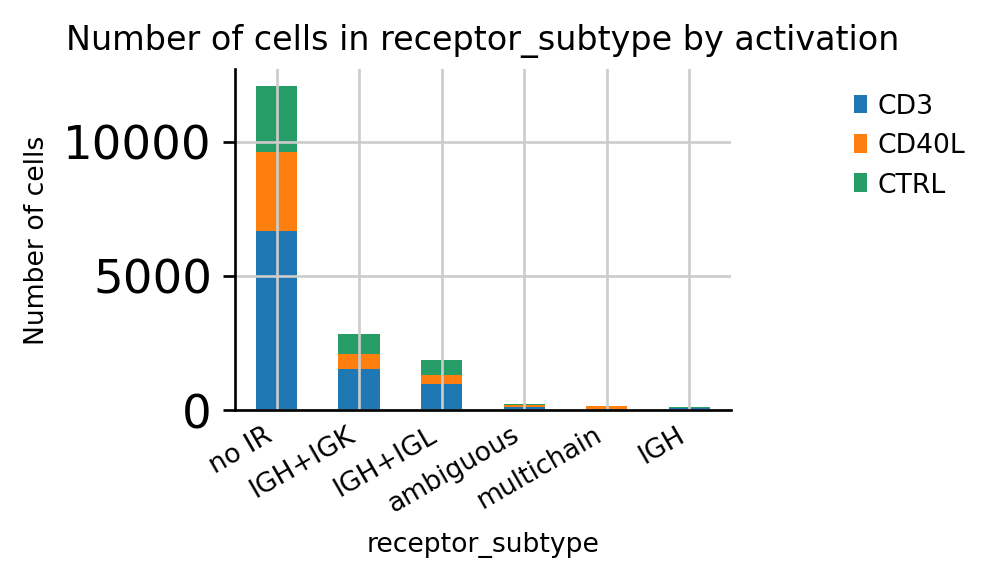

In [36]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="activation")


<AxesSubplot:title={'center':'Number of cells in receptor_subtype by condition'}, xlabel='receptor_subtype', ylabel='Number of cells'>

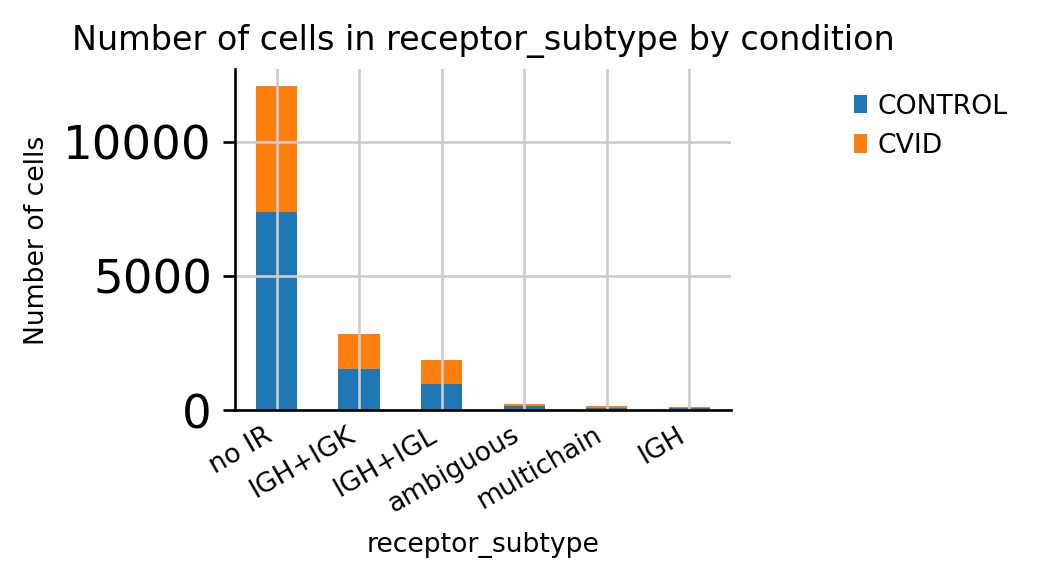

In [37]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="condition")


In [38]:
adata

AnnData object with n_obs × n_vars = 17315 × 2439
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junc

In [39]:
adata.obs['louvain'] = adata.obs['louvain'].astype(str)

... storing 'louvain' as categorical


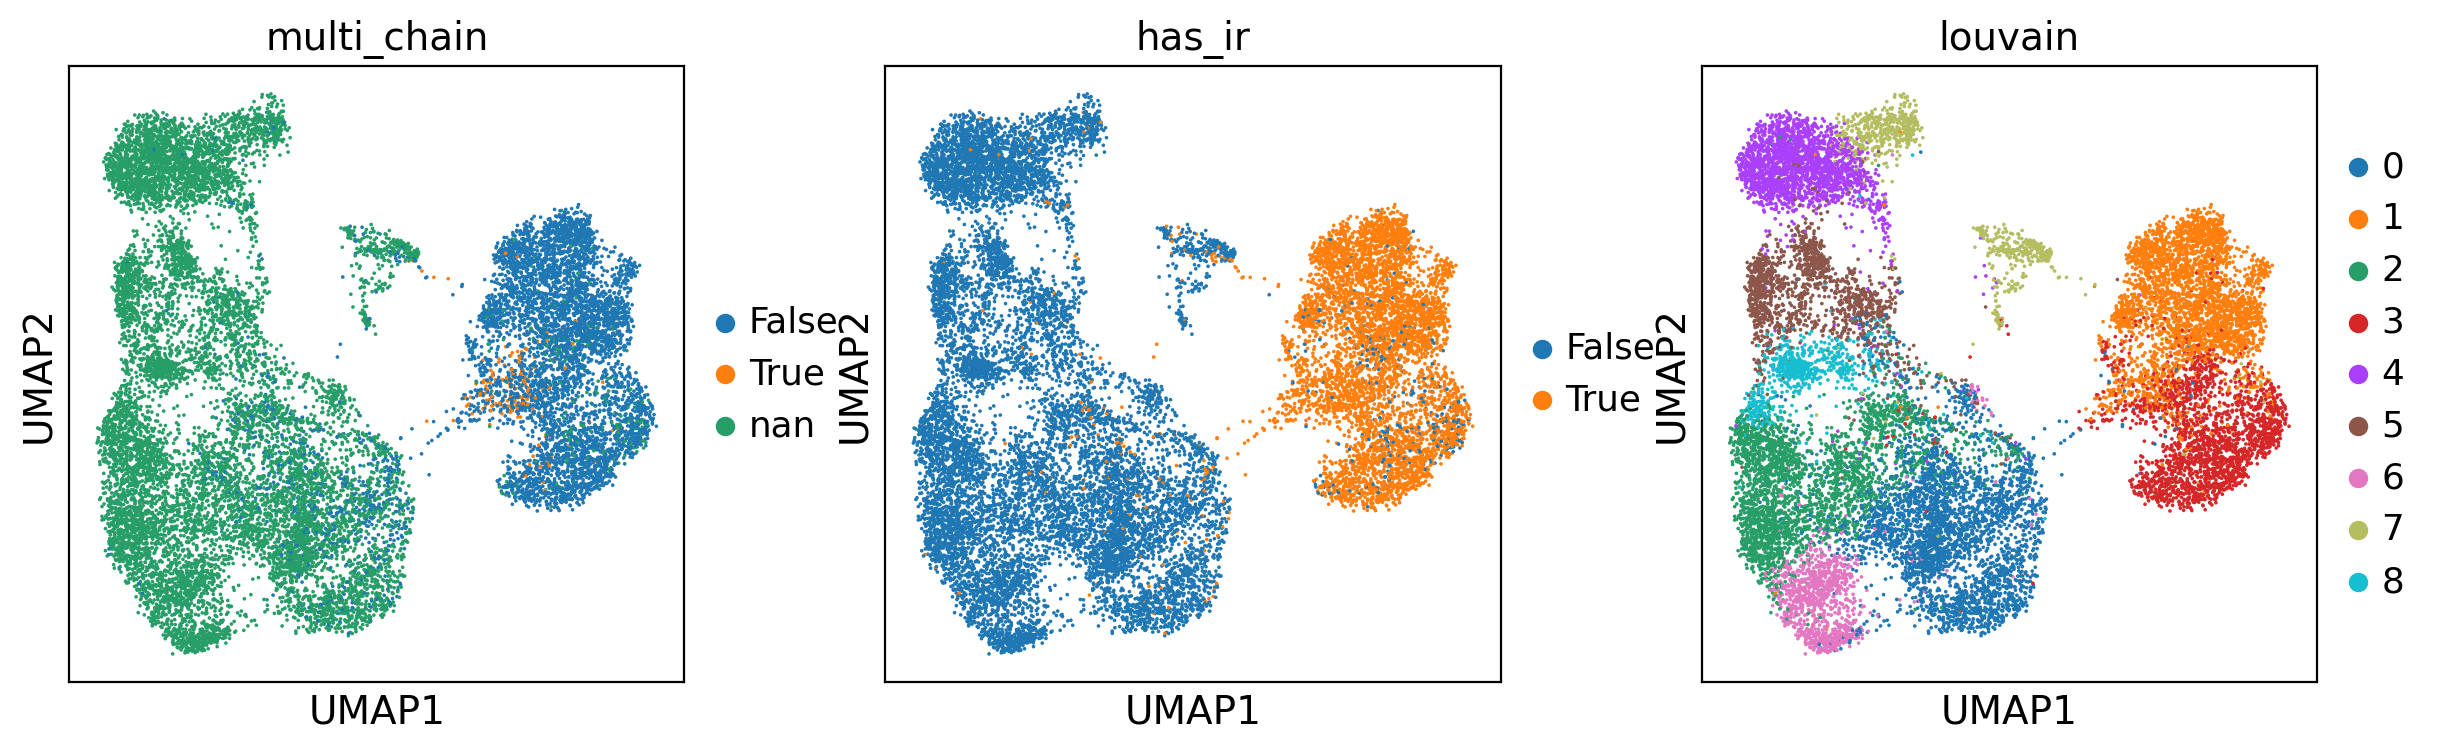

In [40]:
sc.pl.umap(adata, color=['multi_chain','has_ir','louvain'])


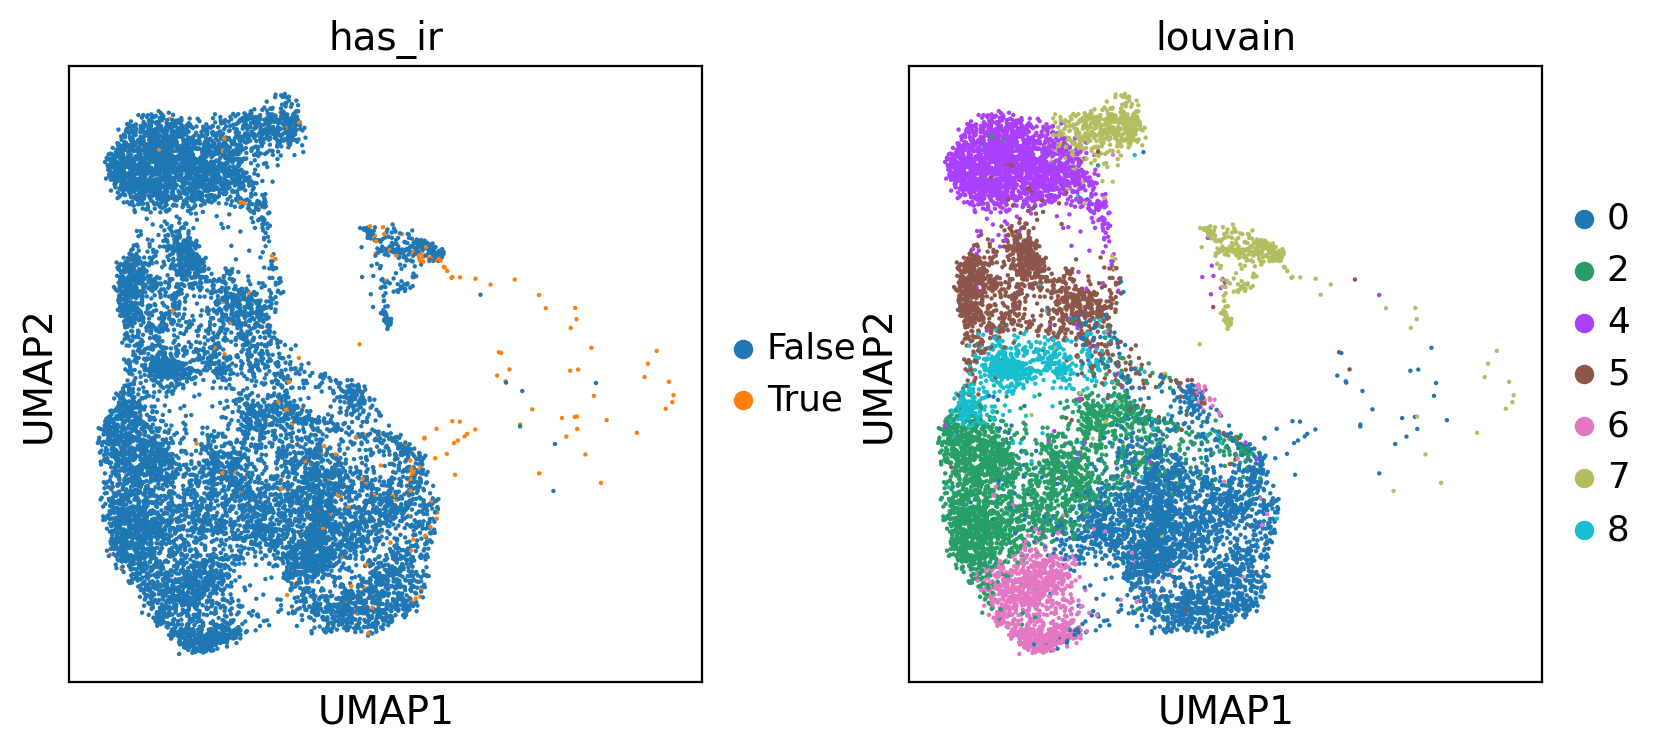

In [44]:
# any BCR data outside B cells (louvain cluster 1)?
sc.pl.umap(adata[-adata.obs['louvain'].isin(['1','3'])], color=['has_ir','louvain'])


In [45]:
# where are these cells that have BCR information but are not in cluster 1 (=B cells)?
np.unique(adata[-adata.obs['louvain'].isin(['1','3'])].obs['louvain'])

array(['0', '2', '4', '5', '6', '7', '8'], dtype=object)

In [46]:
np.unique(adata.obs['has_ir'], return_counts=True)

(array(['False', 'True'], dtype=object), array([12093,  5222]))

In [47]:
np.unique(adata.obs['louvain'], return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dtype=object),
 array([3239, 3184, 2742, 2139, 2005, 1414, 1083,  789,  720]))

In [52]:
# marking cells with BCR information but not in cluster 1 (B cells) as 'doublets_by_BCR'
def mark_doublets_by_BCR(adata_obj, barcode):
    
    curr_louvain = adata_obj.obs.loc[barcode, 'louvain']
    
    # if the cell has BCR information
    has_bcr = adata_obj.obs.loc[barcode, 'has_ir']
    
    #print('louvain', curr_louvain)
    
    #print('has BCR info?', has_bcr, '\n')
    
    if curr_louvain not in ['1','3']:
        if has_bcr == 'True':
            #print('louvain', curr_louvain)
            #print('this cell is not a B cell but has BCR info, returning True', '\n')
            return(True)
        else:
            #print('louvain', curr_louvain)
            #print('this cell is not a B cell and doesnt have BCR info, returning False', '\n')
            return(False)
    else:
        return(False)

In [53]:
adata.obs['barcode'] = adata.obs.index

In [54]:
adata.obs['doublets_by_BCR'] = adata.obs['barcode'].apply(lambda x: mark_doublets_by_BCR(adata,x))

In [55]:
np.unique(adata.obs['doublets_by_BCR'], return_counts=True)

(array([False,  True]), array([17105,   210]))

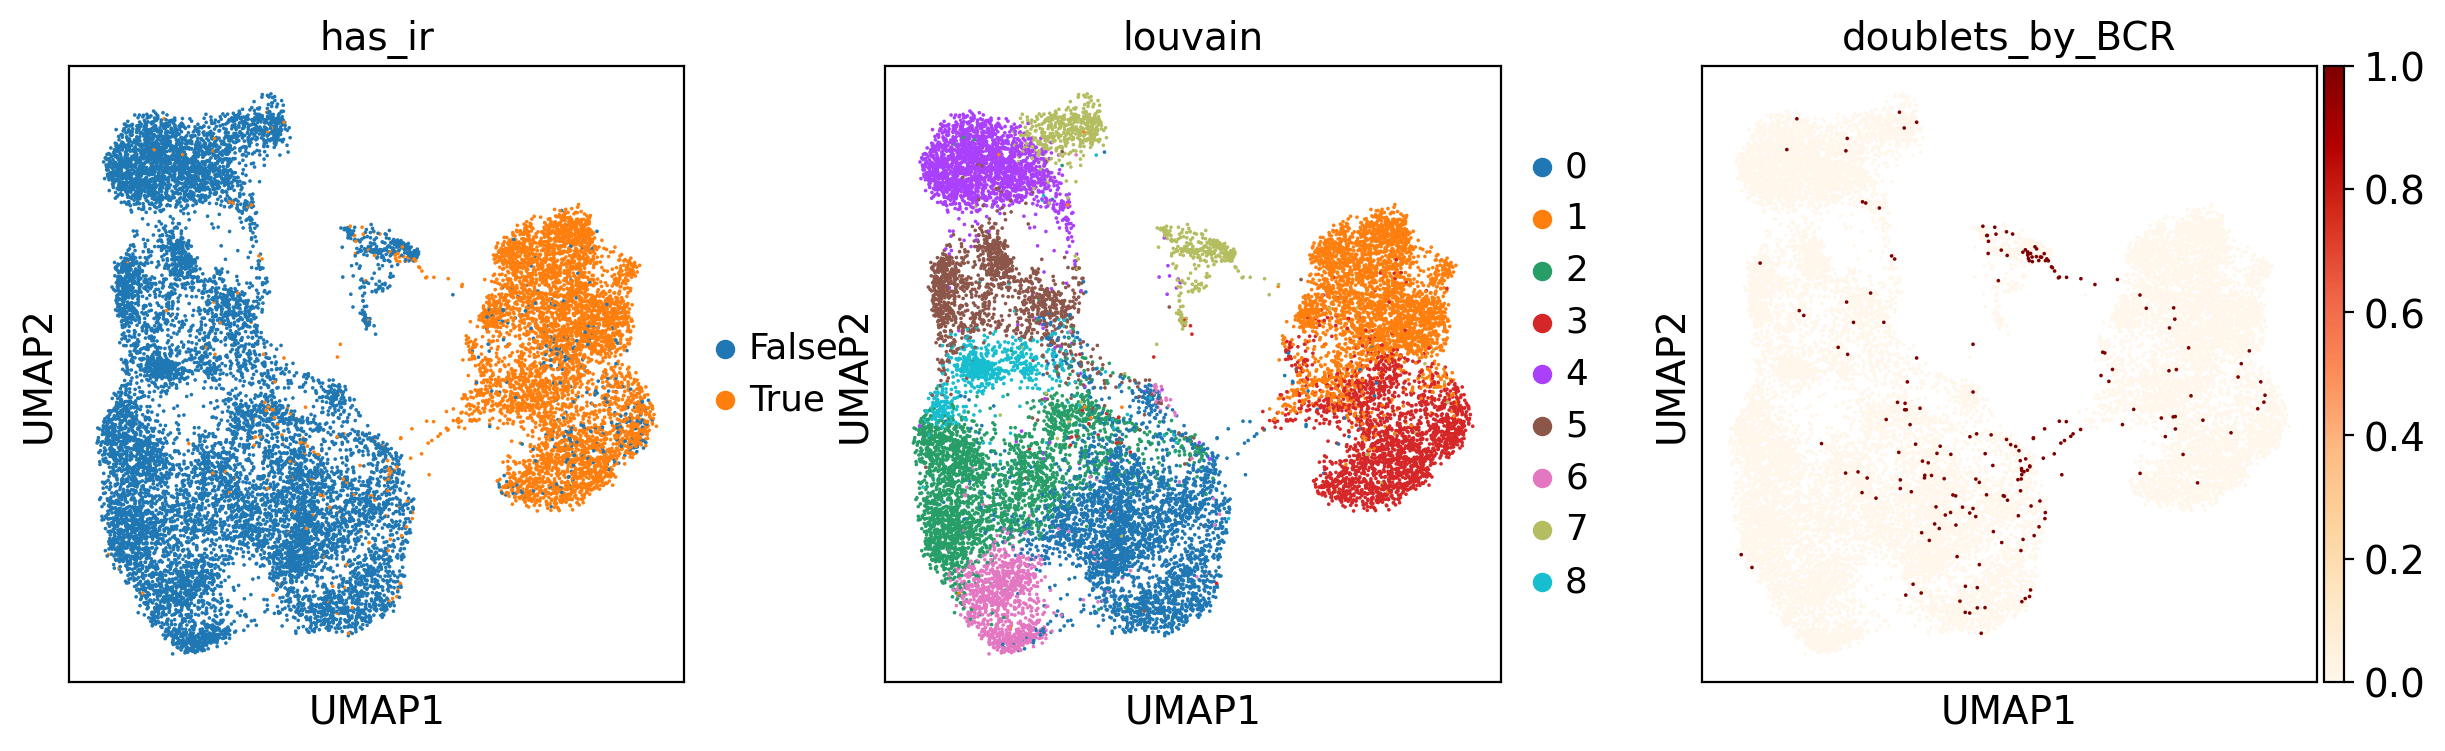

In [57]:
# any BCR data outside B cells (louvain cluster 1)?
sc.pl.umap(adata, color=['has_ir','louvain','doublets_by_BCR'], cmap='OrRd')


In [58]:
adata.obs['doublets_by_BCR'] = adata.obs['doublets_by_BCR'].astype(str)

In [68]:
np.unique(adata[adata.obs['doublets_by_BCR'] == 'True'].obs['louvain'])

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


array(['0', '2', '4', '5', '7', '8'], dtype=object)

... storing 'doublets_by_BCR' as categorical


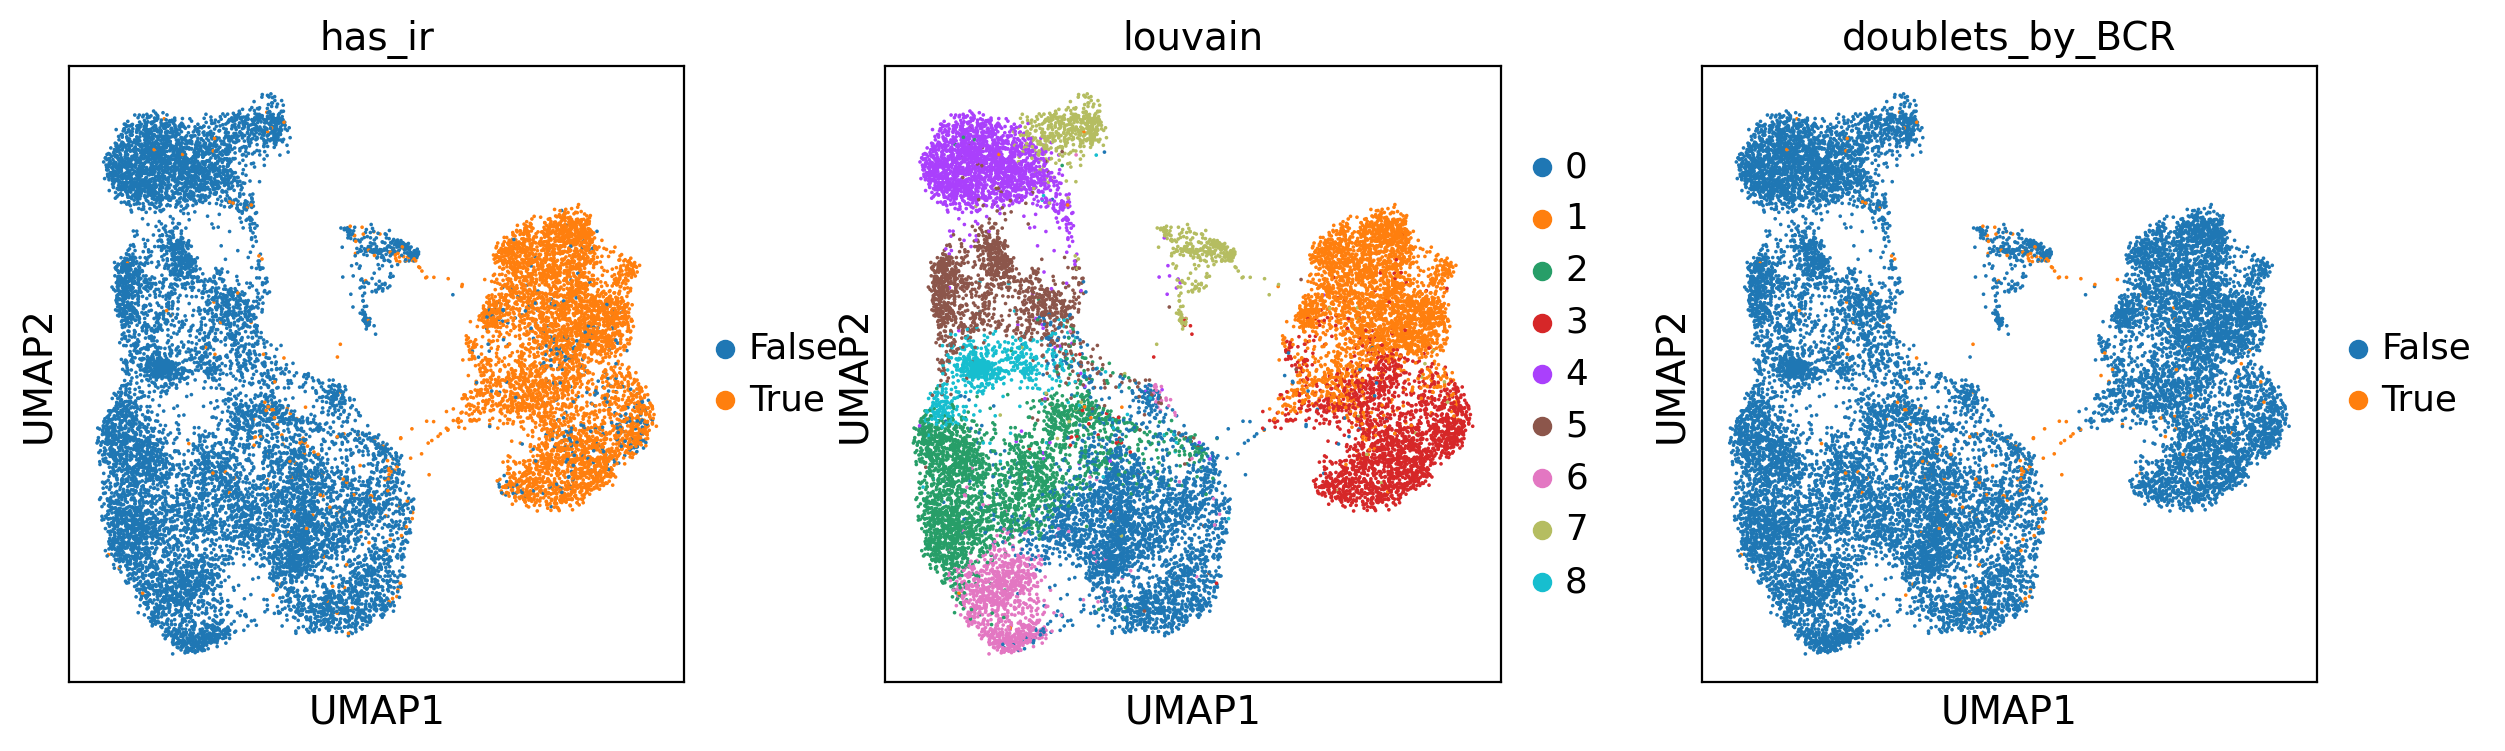

In [59]:
# any BCR data outside B cells (louvain cluster 1)?
sc.pl.umap(adata, color=['has_ir','louvain','doublets_by_BCR'])


In [60]:
adata.obs.loc[:,'doublets_by_BCR']

index
TCAGGATCAGTTTACG-1    False
GATCGCGTCCTACAGA-1    False
CTTGGCTCATTATCTC-1    False
TGTATTCGTACGCTGC-1    False
GTGTTAGGTCCGCTGA-1    False
                      ...  
TTAGGACGTTCGTCTC-1    False
GCGCAGTAGCCTCGTG-1    False
AAGACCTCAAGTAGTA-1    False
TATTACCTCACCCGAG-1    False
CCTTCCCCAACTGCTA-1    False
Name: doublets_by_BCR, Length: 17315, dtype: category
Categories (2, object): ['False', 'True']

In [61]:
doublets_by_BCR = pd.DataFrame(adata.obs.loc[:,'doublets_by_BCR'])

In [62]:
doublets_by_BCR

doublets_by_BCR
index                             
TCAGGATCAGTTTACG-1           False
GATCGCGTCCTACAGA-1           False
CTTGGCTCATTATCTC-1           False
TGTATTCGTACGCTGC-1           False
GTGTTAGGTCCGCTGA-1           False
...                            ...
TTAGGACGTTCGTCTC-1           False
GCGCAGTAGCCTCGTG-1           False
AAGACCTCAAGTAGTA-1           False
TATTACCTCACCCGAG-1           False
CCTTCCCCAACTGCTA-1           False

[17315 rows x 1 columns]

In [63]:
np.unique(doublets_by_BCR['doublets_by_BCR'], return_counts=True)

(array(['False', 'True'], dtype=object), array([17105,   210]))

In [66]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

In [65]:
doublets_by_BCR.to_csv(save_path + 'doublets_by_BCR_table_twins_20210212.csv')

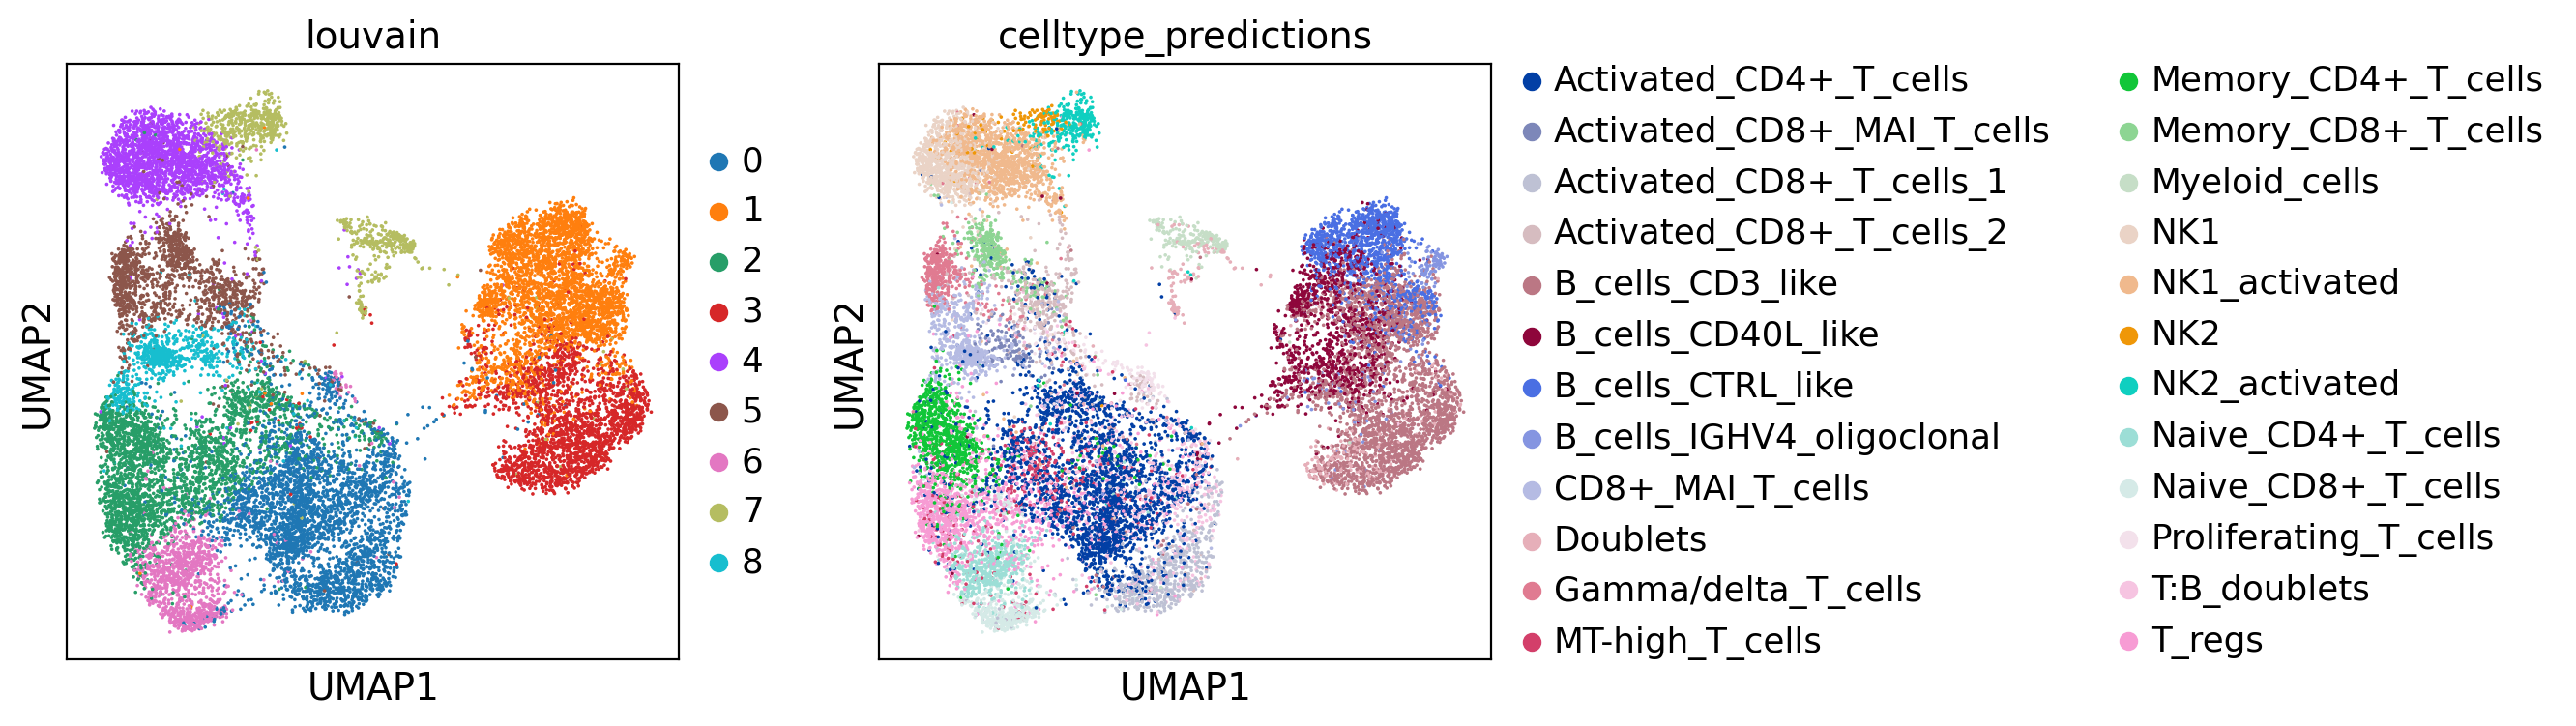

In [67]:
# any BCR data outside B cells (louvain cluster 1)?
sc.pl.umap(adata, color=['louvain','celltype_predictions'])
